In [5]:
# Cài đặt các thư viện cần thiết
# !pip install networkx scikit-learn matplotlib numpy

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform

# Cấu hình hiển thị
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)

In [6]:
# 1. Tạo đồ thị
G = nx.Graph()

# 2. Tạo các nút (Nodes) với tọa độ (pos) để vẽ
# Đường bên trái (Left Street): Tọa độ x=0, y chạy từ 0 đến 10
for i in range(11):
    G.add_node(f"L{i}", pos=(0, i))

# Đường bên phải (Right Street): Tọa độ x=2, y chạy từ 0 đến 10 (Rất gần đường trái về không gian)
for i in range(11):
    G.add_node(f"R{i}", pos=(2, i))

# 3. Tạo cạnh (Edges) - Con đường
# Nối dọc đường bên trái
for i in range(10):
    G.add_edge(f"L{i}", f"L{i+1}", weight=1.0) # Mỗi đoạn dài 1 đơn vị

# Nối dọc đường bên phải
for i in range(10):
    G.add_edge(f"R{i}", f"R{i+1}", weight=1.0)

# *** QUAN TRỌNG ***: Chỉ nối 2 đường này ở đáy (y=0)
# Điều này khiến muốn đi từ L10 sang R10 phải đi vòng xuống đáy chữ U rồi vòng lên (rất xa)
G.add_edge("L0", "R0", weight=2.0) 

# Lấy vị trí để vẽ
pos = nx.get_node_attributes(G, 'pos')

print("Đã tạo mạng lưới hình chữ U!")

Đã tạo mạng lưới hình chữ U!


In [7]:
# Dữ liệu mẫu: Các sự kiện xảy ra ở cuối hai con đường (đỉnh chữ U)
# Về không gian: L10 rất gần R10 (cách nhau x=2)
# Về mạng lưới: L10 rất xa R10 (phải đi xuống L0 rồi sang R0 rồi lên R10)
data_nodes = ['L8', 'L9', 'L10', 'R8', 'R9', 'R10']
n_samples = len(data_nodes)

# Lấy tọa độ thực tế (cho DBSCAN thường)
coords = np.array([pos[n] for n in data_nodes])

# --- TÍNH MA TRẬN KHOẢNG CÁCH ---

# 1. Ma trận Euclidean (Cho DBSCAN thường)
euclidean_dist_matrix = squareform(pdist(coords, metric='euclidean'))

# 2. Ma trận Network (Cho NS-DBSCAN)
network_dist_matrix = np.zeros((n_samples, n_samples))

for i in range(n_samples):
    for j in range(i + 1, n_samples):
        u = data_nodes[i]
        v = data_nodes[j]
        # Tính đường đi ngắn nhất trên đồ thị G
        d = nx.shortest_path_length(G, source=u, target=v, weight='weight')
        network_dist_matrix[i, j] = d
        network_dist_matrix[j, i] = d

print("Dữ liệu mẫu:", data_nodes)
print("\nKhoảng cách Euclidean giữa L10 và R10:", euclidean_dist_matrix[2, 5]) # Sẽ là 2.0
print("Khoảng cách Mạng lưới giữa L10 và R10:", network_dist_matrix[2, 5])   # Sẽ là 22.0 (10 xuống + 2 sang + 10 lên)

Dữ liệu mẫu: ['L8', 'L9', 'L10', 'R8', 'R9', 'R10']

Khoảng cách Euclidean giữa L10 và R10: 2.0
Khoảng cách Mạng lưới giữa L10 và R10: 22.0


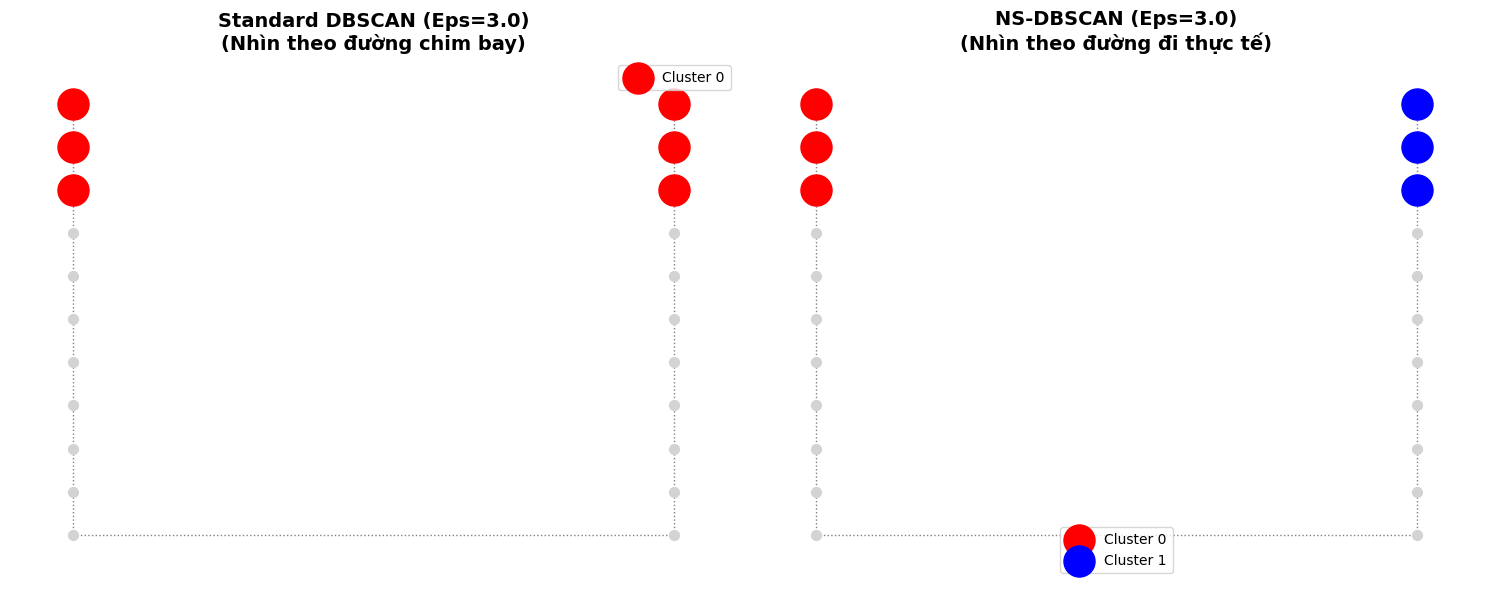

In [8]:
# Thiết lập tham số:
# Eps = 3.0. 
# Với Euclidean: 2.0 < 3.0 (L10 và R10 sẽ gộp cụm)
# Với Network: 22.0 > 3.0 (L10 và R10 sẽ tách cụm)
EPS = 3.0
MIN_SAMPLES = 2

# --- 1. CHẠY STANDARD DBSCAN (EUCLIDEAN) ---
db_euclidean = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='precomputed')
labels_euclidean = db_euclidean.fit_predict(euclidean_dist_matrix)

# --- 2. CHẠY NS-DBSCAN (NETWORK) ---
db_network = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric='precomputed')
labels_network = db_network.fit_predict(network_dist_matrix)

# --- VẼ BIỂU ĐỒ SO SÁNH ---
fig, (ax1, ax2) = plt.subplots(1, 2)

# Hàm vẽ phụ trợ
def plot_result(ax, labels, title):
    # Vẽ nền mạng lưới (màu xám nhạt)
    nx.draw(G, pos, ax=ax, node_color='lightgray', node_size=50, edge_color='gray', style='dotted')
    
    # Vẽ các điểm dữ liệu với màu theo cụm
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    unique_labels = set(labels)
    for k in unique_labels:
        if k == -1:
            # Nhiễu (Noise) màu đen
            col = 'black'
            marker = 'x'
            label_name = "Noise"
        else:
            col = colors[k % len(colors)]
            marker = 'o'
            label_name = f"Cluster {k}"
            
        # Lấy các node thuộc cụm k
        member_indices = [i for i, x in enumerate(labels) if x == k]
        member_nodes = [data_nodes[i] for i in member_indices]
        
        # Vẽ lên đồ thị
        nx.draw_networkx_nodes(G, pos, nodelist=member_nodes, ax=ax, 
                               node_color=col, node_size=500, label=label_name)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend()

# Vẽ biểu đồ trái (Euclidean)
plot_result(ax1, labels_euclidean, f"Standard DBSCAN (Eps={EPS})\n(Nhìn theo đường chim bay)")

# Vẽ biểu đồ phải (Network)
plot_result(ax2, labels_network, f"NS-DBSCAN (Eps={EPS})\n(Nhìn theo đường đi thực tế)")

plt.tight_layout()
plt.show()